In [1]:
# ============================================================
# IBM Telco Customer Churn Prediction with ANN
# ============================================================
# Business Goal: Predict which telecom customers will churn
# Model: Artificial Neural Network (TensorFlow / Keras)
# Encoding: LabelEncoder (avoids feature explosion from OHE)
# ============================================================

In [2]:
# -- Section 1: Imports --

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, roc_auc_score, precision_score,
                             recall_score, f1_score, precision_recall_curve)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import pickle

np.random.seed(42)
tf.random.set_seed(42)

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.20.0


In [3]:
# -- Section 2: Load Data --

df = pd.read_excel('Telco_customer_churn.xlsx')
print('Shape:', df.shape)
df.head()

Shape: (7043, 33)


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   str    
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   str    
 3   State              7043 non-null   str    
 4   City               7043 non-null   str    
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   str    
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   str    
 10  Senior Citizen     7043 non-null   str    
 11  Partner            7043 non-null   str    
 12  Dependents         7043 non-null   str    
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   str    
 15  Multiple Lines     7043 non-null   str    
 16  Internet Service   7043 non-null   

In [5]:
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


In [6]:
# Check target distribution
print('Churn Label distribution:')
print(df['Churn Label'].value_counts())
print()
print('Churn Value distribution:')
print(df['Churn Value'].value_counts())

Churn Label distribution:
Churn Label
No     5174
Yes    1869
Name: count, dtype: int64

Churn Value distribution:
Churn Value
0    5174
1    1869
Name: count, dtype: int64


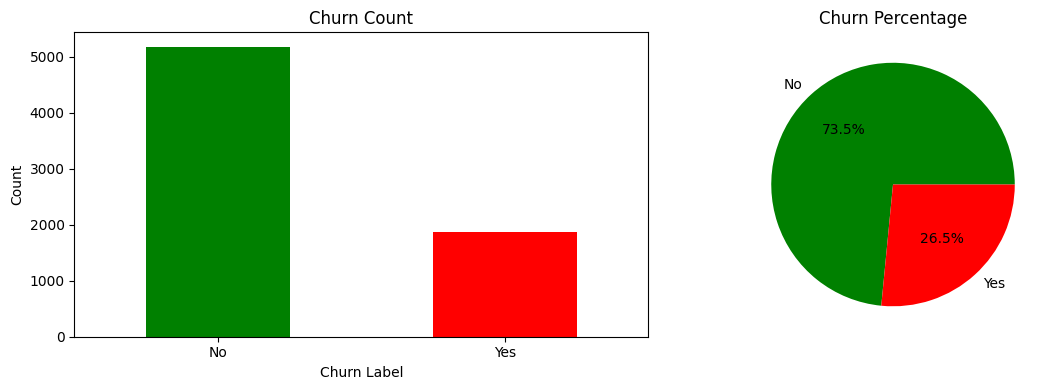

In [7]:
# Churn distribution plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df['Churn Label'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Churn Count')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No', 'Yes'], rotation=0)

df['Churn Label'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['green', 'red'])
axes[1].set_title('Churn Percentage')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [8]:
# -- Section 3: Data Cleaning --

# Drop columns that are not useful for prediction
# CustomerID      - unique identifier, no predictive value
# Count           - constant value
# Country         - only one unique value
# State           - geographic info already covered by other columns
# City            - too many unique values, not useful for ANN
# Zip Code        - too many unique values
# Lat Long        - string representation of lat/long
# Latitude        - geographic, not relevant for churn behavior
# Longitude       - geographic, not relevant for churn behavior
# Churn Label     - text version of target, we use Churn Value instead
# Churn Score     - leakage, this is a pre-computed score
# CLTV            - leakage, derived metric
# Churn Reason    - leakage, only available after churn happens

drop_cols = ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
             'Lat Long', 'Latitude', 'Longitude', 'Churn Label',
             'Churn Score', 'CLTV', 'Churn Reason']

df = df.drop(columns=drop_cols)
print('Shape after dropping:', df.shape)
print('\nRemaining columns:')
print(df.columns.tolist())

Shape after dropping: (7043, 20)

Remaining columns:
['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value']


In [9]:
# Handle Total Charges (object type, has blanks that became spaces)
print('Total Charges dtype:', df['Total Charges'].dtype)

df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

missing = df['Total Charges'].isnull().sum()
print('Missing values in Total Charges:', missing)

if missing > 0:
    median_val = df['Total Charges'].median()
    df['Total Charges'] = df['Total Charges'].fillna(median_val)
    print('Filled with median:', median_val)

# Safety net: drop any remaining rows with NaN
df = df.dropna()

print('\nNull check after cleaning:')
print(df.isnull().sum().sum(), 'total nulls')
print('Shape after cleaning:', df.shape)

Total Charges dtype: object
Missing values in Total Charges: 11
Filled with median: 1397.475

Null check after cleaning:
0 total nulls
Shape after cleaning: (7043, 20)


In [10]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()

# Remove target from numerical list
numerical_cols.remove('Churn Value')

print('Numerical columns:', numerical_cols)
print('\nCategorical columns:', categorical_cols)

Numerical columns: ['Tenure Months', 'Monthly Charges', 'Total Charges']

Categorical columns: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']


In [11]:
# Print unique values for each categorical column
for col in categorical_cols:
    print(f'{col}: {df[col].nunique()} unique -> {df[col].unique()}')

Gender: 2 unique -> <StringArray>
['Male', 'Female']
Length: 2, dtype: str
Senior Citizen: 2 unique -> <StringArray>
['No', 'Yes']
Length: 2, dtype: str
Partner: 2 unique -> <StringArray>
['No', 'Yes']
Length: 2, dtype: str
Dependents: 2 unique -> <StringArray>
['No', 'Yes']
Length: 2, dtype: str
Phone Service: 2 unique -> <StringArray>
['Yes', 'No']
Length: 2, dtype: str
Multiple Lines: 3 unique -> <StringArray>
['No', 'Yes', 'No phone service']
Length: 3, dtype: str
Internet Service: 3 unique -> <StringArray>
['DSL', 'Fiber optic', 'No']
Length: 3, dtype: str
Online Security: 3 unique -> <StringArray>
['Yes', 'No', 'No internet service']
Length: 3, dtype: str
Online Backup: 3 unique -> <StringArray>
['Yes', 'No', 'No internet service']
Length: 3, dtype: str
Device Protection: 3 unique -> <StringArray>
['No', 'Yes', 'No internet service']
Length: 3, dtype: str
Tech Support: 3 unique -> <StringArray>
['No', 'Yes', 'No internet service']
Length: 3, dtype: str
Streaming TV: 3 unique -> <

In [12]:
# -- Section 4: Label Encoding --
# Why Label Encoding instead of OHE?
# - OHE creates a new column for each category, causing feature explosion
# - Label Encoding keeps the feature count low and is efficient
# - Works well with neural networks since they learn non-linear relationships

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f'{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}')

print('\nEncoding complete. Shape:', df.shape)

Gender: {'Female': np.int64(0), 'Male': np.int64(1)}
Senior Citizen: {'No': np.int64(0), 'Yes': np.int64(1)}
Partner: {'No': np.int64(0), 'Yes': np.int64(1)}
Dependents: {'No': np.int64(0), 'Yes': np.int64(1)}
Phone Service: {'No': np.int64(0), 'Yes': np.int64(1)}
Multiple Lines: {'No': np.int64(0), 'No phone service': np.int64(1), 'Yes': np.int64(2)}
Internet Service: {'DSL': np.int64(0), 'Fiber optic': np.int64(1), 'No': np.int64(2)}
Online Security: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
Online Backup: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
Device Protection: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
Tech Support: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
Streaming TV: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
Streaming Movies: {'No': np.int64(0), 'No internet service': np.int64(1), 'Yes': np.int64(2)}
Contrac

In [13]:
# -- Section 5: Train-Test Split and Scaling --

X = df.drop('Churn Value', axis=1)
y = df['Churn Value']

print('Features:', X.shape)
print('Target:', y.shape)
print('Target distribution:', y.value_counts().to_dict())

Features: (7043, 19)
Target: (7043,)
Target distribution: {0: 5174, 1: 1869}


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Train:', X_train.shape, '| Test:', X_test.shape)

Train: (5634, 19) | Test: (1409, 19)


In [15]:
# StandardScaler: fit ONLY on training data to prevent data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify no NaN values in scaled data
assert not np.isnan(X_train_scaled).any(), 'NaN found in training data after scaling'
assert not np.isnan(X_test_scaled).any(), 'NaN found in test data after scaling'

print('Scaling done - no NaN values')
print('Train mean:', round(float(np.nanmean(X_train_scaled)), 4))
print('Train std:', round(float(np.nanstd(X_train_scaled)), 4))

Scaling done - no NaN values
Train mean: -0.0
Train std: 1.0


In [16]:
# -- Section 6: Baseline ANN (NO Regularization) --
# Purpose: show that a plain network overfits the training data
#
# Why ReLU for hidden layers?
#   - Does not suffer from vanishing gradient (unlike sigmoid/tanh)
#   - Computationally cheap: max(0, x)
#   - Introduces non-linearity so the network can learn complex patterns
#
# Why Sigmoid for output layer?
#   - Squashes output between 0 and 1 which represents churn probability
#   - Perfect for binary classification
#
# Why Binary Crossentropy?
#   - Standard loss for binary classification
#   - Penalizes confident wrong predictions heavily
#
# Why Adam optimizer?
#   - Adaptive learning rate per parameter
#   - Combines Momentum + RMSProp advantages
#   - Fast convergence with minimal hyperparameter tuning

tf.keras.backend.clear_session()
input_dim = X_train_scaled.shape[1]

model_baseline = Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_baseline.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history_baseline = model_baseline.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7597 - loss: 0.4693 - val_accuracy: 0.7879 - val_loss: 0.4367
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8085 - loss: 0.4027 - val_accuracy: 0.7844 - val_loss: 0.4320
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8127 - loss: 0.3929 - val_accuracy: 0.7835 - val_loss: 0.4304
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8163 - loss: 0.3867 - val_accuracy: 0.7853 - val_loss: 0.4296
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8185 - loss: 0.3820 - val_accuracy: 0.7826 - val_loss: 0.4288
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8225 - loss: 0.3781 - val_accuracy: 0.7817 - val_loss: 0.4285
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8254 - loss: 0.3748 - val_accuracy: 0.7799 - val_loss: 0.4293
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8269 - loss: 0.3717 - val_accu

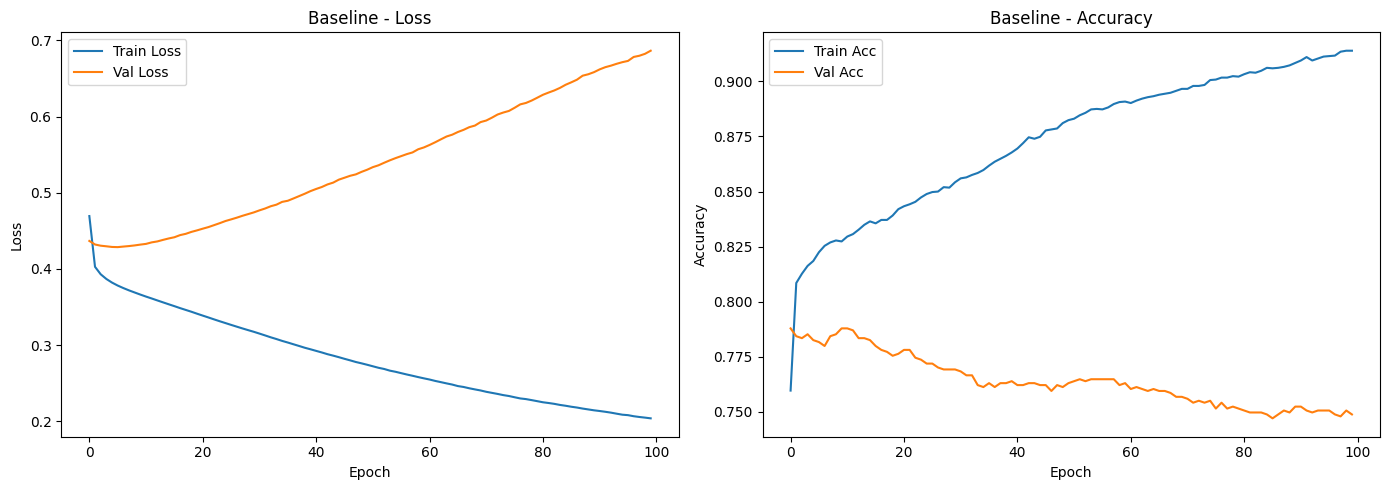

Train Loss: 0.2038 | Val Loss: 0.6864
Train Acc:  0.9139 | Val Acc:  0.7489
Overfitting gap (loss): 0.4826


In [18]:
# Plot baseline training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_baseline.history['loss'], label='Train Loss')
axes[0].plot(history_baseline.history['val_loss'], label='Val Loss')
axes[0].set_title('Baseline - Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history_baseline.history['accuracy'], label='Train Acc')
axes[1].plot(history_baseline.history['val_accuracy'], label='Val Acc')
axes[1].set_title('Baseline - Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

bl_train_loss = history_baseline.history['loss'][-1]
bl_val_loss = history_baseline.history['val_loss'][-1]
bl_train_acc = history_baseline.history['accuracy'][-1]
bl_val_acc = history_baseline.history['val_accuracy'][-1]

print(f'Train Loss: {bl_train_loss:.4f} | Val Loss: {bl_val_loss:.4f}')
print(f'Train Acc:  {bl_train_acc:.4f} | Val Acc:  {bl_val_acc:.4f}')
print(f'Overfitting gap (loss): {bl_val_loss - bl_train_loss:.4f}')

In [19]:
# -- Section 7: Regularized ANN (Dropout + L2) --
# Dropout: randomly switches off neurons during training to prevent co-adaptation
# L2: adds penalty for large weights, keeps weights small and model simple
# EarlyStopping: stops training when val_loss stops improving

tf.keras.backend.clear_session()

model_reg = Sequential([
    Dense(64, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_reg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_reg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history_reg = model_reg.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/150
108/141 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.7275 - loss: 0.6064
Epoch 1: val_loss improved from None to 0.50522, saving model to best_model.h5



Epoch 1: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7626 - loss: 0.5547 - val_accuracy: 0.7888 - val_loss: 0.5052
Epoch 2/150
105/141 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.7936 - loss: 0.4876
Epoch 2: val_loss improved from 0.50522 to 0.49268, saving model to best_model.h5



Epoch 2: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7937 - loss: 0.4915 - val_accuracy: 0.7915 - val_loss: 0.4927
Epoch 3/150
111/141 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.7958 - loss: 0.4802
Epoch 3: val_loss improved from 0.49268 to 0.48445, saving model to best_model.h5



Epoch 3: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8016 - loss: 0.4785 - val_accuracy: 0.7915 - val_loss: 0.4844
Epoch 4/150
110/141 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.8045 - loss: 0.4664
Epoch 4: val_loss improved from 0.48445 to 0.47771, saving model to best_model.h5



Epoch 4: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8059 - loss: 0.4718 - val_accuracy: 0.7941 - val_loss: 0.4777
Epoch 5/150
102/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8064 - loss: 0.4510
Epoch 5: val_loss improved from 0.47771 to 0.47286, saving model to best_model.h5



Epoch 5: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8083 - loss: 0.4546 - val_accuracy: 0.7950 - val_loss: 0.4729
Epoch 6/150
108/141 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.8004 - loss: 0.4454
Epoch 6: val_loss improved from 0.47286 to 0.46790, saving model to best_model.h5



Epoch 6: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8070 - loss: 0.4496 - val_accuracy: 0.7986 - val_loss: 0.4679
Epoch 7/150
113/141 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.8095 - loss: 0.4491
Epoch 7: val_loss improved from 0.46790 to 0.46535, saving model to best_model.h5



Epoch 7: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8096 - loss: 0.4488 - val_accuracy: 0.7959 - val_loss: 0.4653
Epoch 8/150
107/141 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.8115 - loss: 0.4393
Epoch 8: val_loss improved from 0.46535 to 0.46109, saving model to best_model.h5



Epoch 8: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8114 - loss: 0.4419 - val_accuracy: 0.7950 - val_loss: 0.4611
Epoch 9/150
107/141 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.8097 - loss: 0.4324
Epoch 9: val_loss improved from 0.46109 to 0.45903, saving model to best_model.h5



Epoch 9: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8132 - loss: 0.4380 - val_accuracy: 0.7968 - val_loss: 0.4590
Epoch 10/150
108/141 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.8169 - loss: 0.4283
Epoch 10: val_loss improved from 0.45903 to 0.45695, saving model to best_model.h5



Epoch 10: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8147 - loss: 0.4311 - val_accuracy: 0.7950 - val_loss: 0.4569
Epoch 11/150
118/141 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.8160 - loss: 0.4248
Epoch 11: val_loss improved from 0.45695 to 0.45491, saving model to best_model.h5



Epoch 11: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8158 - loss: 0.4326 - val_accuracy: 0.7977 - val_loss: 0.4549
Epoch 12/150
115/141 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.8079 - loss: 0.4262
Epoch 12: val_loss improved from 0.45491 to 0.45282, saving model to best_model.h5



Epoch 12: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8112 - loss: 0.4283 - val_accuracy: 0.7977 - val_loss: 0.4528
Epoch 13/150
103/141 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.8131 - loss: 0.4206
Epoch 13: val_loss improved from 0.45282 to 0.45130, saving model to best_model.h5



Epoch 13: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8185 - loss: 0.4227 - val_accuracy: 0.7906 - val_loss: 0.4513
Epoch 14/150
111/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8204 - loss: 0.4174
Epoch 14: val_loss improved from 0.45130 to 0.45097, saving model to best_model.h5



Epoch 14: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8194 - loss: 0.4176 - val_accuracy: 0.7950 - val_loss: 0.4510
Epoch 15/150
134/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8131 - loss: 0.4182
Epoch 15: val_loss improved from 0.45097 to 0.44845, saving model to best_model.h5



Epoch 15: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8167 - loss: 0.4197 - val_accuracy: 0.7950 - val_loss: 0.4485
Epoch 16/150
107/141 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.8219 - loss: 0.4180
Epoch 16: val_loss improved from 0.44845 to 0.44707, saving model to best_model.h5



Epoch 16: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8227 - loss: 0.4201 - val_accuracy: 0.7941 - val_loss: 0.4471
Epoch 17/150
121/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8182 - loss: 0.4124
Epoch 17: val_loss improved from 0.44707 to 0.44697, saving model to best_model.h5



Epoch 17: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8212 - loss: 0.4160 - val_accuracy: 0.7933 - val_loss: 0.4470
Epoch 18/150
118/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8178 - loss: 0.4118
Epoch 18: val_loss did not improve from 0.44697
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8187 - loss: 0.4104 - val_accuracy: 0.7950 - val_loss: 0.4476
Epoch 19/150
108/141 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.8244 - loss: 0.4073
Epoch 19: val_loss improved from 0.44697 to 0.44351, saving model to best_model.h5



Epoch 19: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8216 - loss: 0.4153 - val_accuracy: 0.7924 - val_loss: 0.4435
Epoch 20/150
113/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8237 - loss: 0.4056
Epoch 20: val_loss improved from 0.44351 to 0.44317, saving model to best_model.h5



Epoch 20: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8221 - loss: 0.4095 - val_accuracy: 0.7941 - val_loss: 0.4432
Epoch 21/150
107/141 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.8260 - loss: 0.4082
Epoch 21: val_loss improved from 0.44317 to 0.44282, saving model to best_model.h5



Epoch 21: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8185 - loss: 0.4103 - val_accuracy: 0.7977 - val_loss: 0.4428
Epoch 22/150
 95/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8120 - loss: 0.4100  
Epoch 22: val_loss improved from 0.44282 to 0.44082, saving model to best_model.h5



Epoch 22: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8194 - loss: 0.4114 - val_accuracy: 0.8012 - val_loss: 0.4408
Epoch 23/150
104/141 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.8160 - loss: 0.4087
Epoch 23: val_loss did not improve from 0.44082
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8172 - loss: 0.4084 - val_accuracy: 0.7906 - val_loss: 0.4432
Epoch 24/150
131/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8202 - loss: 0.4030
Epoch 24: val_loss did not improve from 0.44082
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8212 - loss: 0.4061 - val_accuracy: 0.7959 - val_loss: 0.4415
Epoch 25/150
112/141 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.8239 - loss: 0.4009
Epoch 25: val_loss did not improve from 0.44082
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8214 - loss: 0.4037 - val_accuracy: 0.7941 - val_loss: 0.4411
Epoch 26/150
 99/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.82


Epoch 27: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8260 - loss: 0.4016 - val_accuracy: 0.7986 - val_loss: 0.4395
Epoch 28/150
102/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8215 - loss: 0.4049
Epoch 28: val_loss did not improve from 0.43953
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8223 - loss: 0.4036 - val_accuracy: 0.7950 - val_loss: 0.4410
Epoch 29/150
109/141 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.8253 - loss: 0.4004
Epoch 29: val_loss did not improve from 0.43953
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8238 - loss: 0.4021 - val_accuracy: 0.7995 - val_loss: 0.4399
Epoch 30/150
105/141 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.8248 - loss: 0.3961
Epoch 30: val_loss improved from 0.43953 to 0.43824, saving model to best_model.h5



Epoch 30: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8292 - loss: 0.3977 - val_accuracy: 0.8021 - val_loss: 0.4382
Epoch 31/150
105/141 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.8299 - loss: 0.3981
Epoch 31: val_loss improved from 0.43824 to 0.43730, saving model to best_model.h5



Epoch 31: finished saving model to best_model.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8276 - loss: 0.4028 - val_accuracy: 0.7995 - val_loss: 0.4373
Epoch 32/150
100/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8241 - loss: 0.3978
Epoch 32: val_loss did not improve from 0.43730
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8245 - loss: 0.3996 - val_accuracy: 0.7959 - val_loss: 0.4414
Epoch 33/150
104/141 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.8279 - loss: 0.3921
Epoch 33: val_loss did not improve from 0.43730
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8263 - loss: 0.3963 - val_accuracy: 0.7959 - val_loss: 0.4403
Epoch 34/150
 99/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8223 - loss: 0.3931
Epoch 34: val_loss did not improve from 0.43730
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8265 - loss: 0.3955 - val_accuracy: 0.7950 - val_loss: 0.4379
Epoch 35/150
115/141 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.82

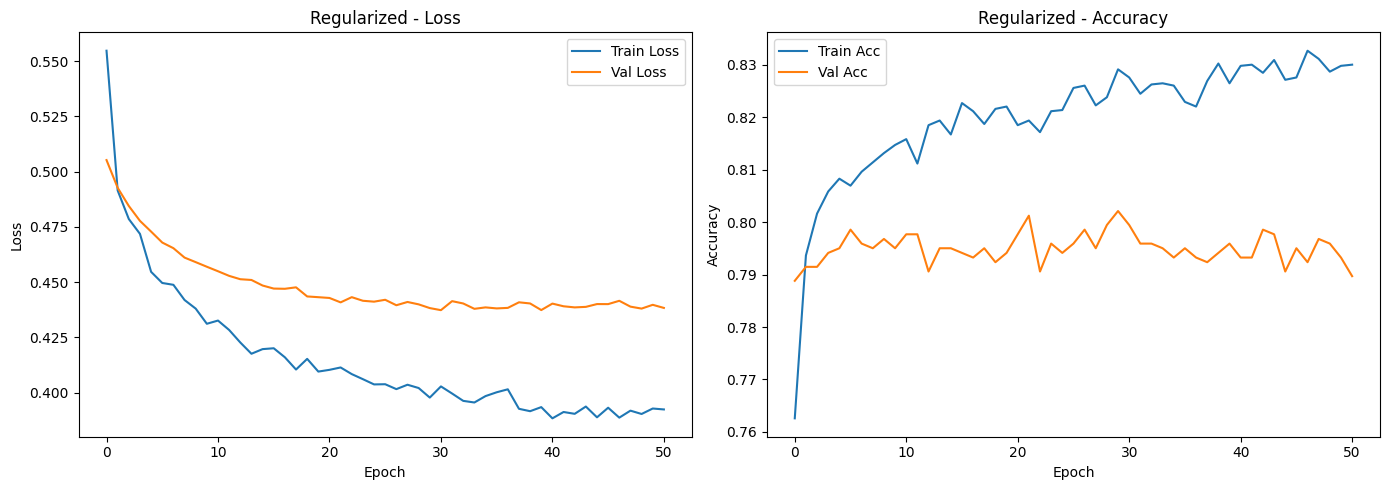

Best Train Loss: 0.3883 | Best Val Loss: 0.4373
Best Train Acc:  0.8327 | Best Val Acc:  0.8021


In [21]:
# Plot regularized training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_reg.history['loss'], label='Train Loss')
axes[0].plot(history_reg.history['val_loss'], label='Val Loss')
axes[0].set_title('Regularized - Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history_reg.history['accuracy'], label='Train Acc')
axes[1].plot(history_reg.history['val_accuracy'], label='Val Acc')
axes[1].set_title('Regularized - Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

# Use best (min loss / max acc) from history for robust comparison
reg_train_loss = min(history_reg.history['loss'])
reg_val_loss = min(history_reg.history['val_loss'])
reg_train_acc = max(history_reg.history['accuracy'])
reg_val_acc = max(history_reg.history['val_accuracy'])

print(f'Best Train Loss: {reg_train_loss:.4f} | Best Val Loss: {reg_val_loss:.4f}')
print(f'Best Train Acc:  {reg_train_acc:.4f} | Best Val Acc:  {reg_val_acc:.4f}')

In [22]:
# Compare baseline vs regularized
comparison = pd.DataFrame({
    'Model': ['Baseline', 'Regularized'],
    'Train Loss': [bl_train_loss, reg_train_loss],
    'Val Loss': [bl_val_loss, reg_val_loss],
    'Train Acc': [bl_train_acc, reg_train_acc],
    'Val Acc': [bl_val_acc, reg_val_acc],
    'Overfit Gap': [bl_val_loss - bl_train_loss, reg_val_loss - reg_train_loss]
})
print(comparison.to_string(index=False))

      Model  Train Loss  Val Loss  Train Acc  Val Acc  Overfit Gap
   Baseline    0.203770  0.686364   0.913912 0.748891     0.482595
Regularized    0.388346  0.437300   0.832705 0.802130     0.048954


In [23]:
# -- Section 8: Hyperparameter Tuning --

configs = [
    {'name': 'A', 'layers': [128, 64], 'dropout': 0.3, 'l2_val': 0.001, 'lr': 0.001, 'batch': 32},
    {'name': 'B', 'layers': [64, 32], 'dropout': 0.4, 'l2_val': 0.01,  'lr': 0.001, 'batch': 64},
    {'name': 'C', 'layers': [128, 64, 32], 'dropout': 0.2, 'l2_val': 0.001, 'lr': 0.0005, 'batch': 32},
    {'name': 'D', 'layers': [256, 128, 64], 'dropout': 0.3, 'l2_val': 0.001, 'lr': 0.001, 'batch': 64},
]

tuning_results = []

for cfg in configs:
    tf.keras.backend.clear_session()
    
    m = Sequential()
    m.add(Dense(cfg['layers'][0], activation='relu', input_dim=input_dim, kernel_regularizer=l2(cfg['l2_val'])))
    m.add(Dropout(cfg['dropout']))
    for units in cfg['layers'][1:]:
        m.add(Dense(units, activation='relu', kernel_regularizer=l2(cfg['l2_val'])))
        m.add(Dropout(cfg['dropout']))
    m.add(Dense(1, activation='sigmoid'))
    
    opt = tf.keras.optimizers.Adam(learning_rate=cfg['lr'])
    m.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
    h = m.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100,
              batch_size=cfg['batch'], callbacks=[es], verbose=0)
    
    best_val_loss = min(h.history['val_loss'])
    best_val_acc = max(h.history['val_accuracy'])
    tuning_results.append({'Config': cfg['name'], 'Layers': str(cfg['layers']),
                           'Dropout': cfg['dropout'], 'L2': cfg['l2_val'],
                           'LR': cfg['lr'], 'Batch': cfg['batch'],
                           'Val Loss': round(best_val_loss, 4),
                           'Val Acc': round(best_val_acc, 4)})
    print(f'Config {cfg["name"]}: Val Loss={best_val_loss:.4f}, Val Acc={best_val_acc:.4f}')

results_df = pd.DataFrame(tuning_results)
print('\n', results_df.to_string(index=False))

# Handle potential NaN values in results
valid_results = results_df.dropna(subset=['Val Loss'])
if len(valid_results) > 0:
    best = valid_results.loc[valid_results['Val Loss'].idxmin()]
    print(f'\nBest: Config {best["Config"]} with Val Loss {best["Val Loss"]}')
else:
    print('\nWarning: No valid results found')

Config A: Val Loss=0.4453, Val Acc=0.7968
Config B: Val Loss=0.4403, Val Acc=0.8021
Config C: Val Loss=0.4613, Val Acc=0.7924
Config D: Val Loss=0.4569, Val Acc=0.7941

 Config         Layers  Dropout    L2     LR  Batch  Val Loss  Val Acc
     A      [128, 64]      0.3 0.001 0.0010     32    0.4453   0.7968
     B       [64, 32]      0.4 0.010 0.0010     64    0.4403   0.8021
     C  [128, 64, 32]      0.2 0.001 0.0005     32    0.4613   0.7924
     D [256, 128, 64]      0.3 0.001 0.0010     64    0.4569   0.7941

Best: Config B with Val Loss 0.4403


In [24]:
# -- Section 9: Evaluate on Test Set --

test_loss, test_acc = model_reg.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Test Loss: 0.4292
Test Accuracy: 0.7991


In [25]:
y_pred_proba = model_reg.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

              precision    recall  f1-score   support

    No Churn       0.85      0.88      0.87      1035
       Churn       0.63      0.59      0.61       374

    accuracy                           0.80      1409
   macro avg       0.74      0.73      0.74      1409
weighted avg       0.79      0.80      0.80      1409



In [26]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy: ', round(test_acc, 4))
print('Precision:', round(precision, 4))
print('Recall:   ', round(recall, 4))
print('F1 Score: ', round(f1, 4))

Accuracy:  0.7991
Precision: 0.6311
Recall:    0.5856
F1 Score:  0.6075


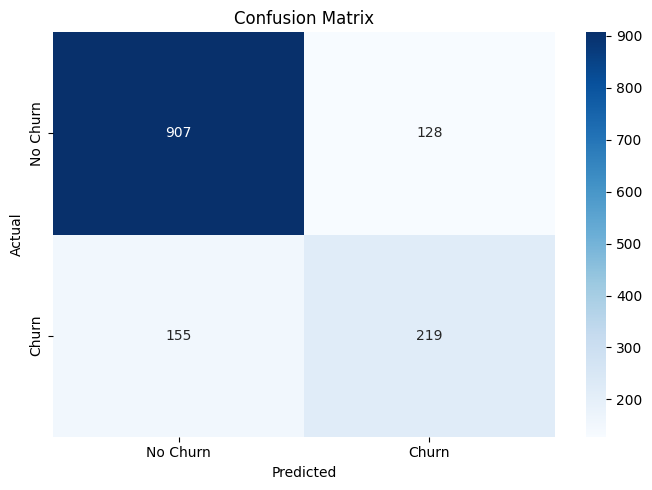

TN=907, FP=128, FN=155, TP=219


In [27]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f'TN={tn}, FP={fp}, FN={fn}, TP={tp}')

In [28]:
# Business Interpretation of Errors
#
# False Positive (FP): predicted churn but customer stayed
#   - Business cost: wasted retention budget (discounts, offers)
#   - Severity: MODERATE
#
# False Negative (FN): predicted stay but customer churned
#   - Business cost: lost revenue and customer lifetime value
#   - Severity: HIGH - missed opportunity to retain customer
#
# In telecom churn, FN is more costly than FP
# Consider lowering threshold below 0.5 to catch more churners (higher recall)

print('Business Impact Summary:')
print(f'Correctly identified churners (TP): {tp}')
print(f'Missed churners (FN): {fn} -- HIGH COST')
print(f'False alarms (FP): {fp} -- moderate cost')
print(f'Correctly identified non-churners (TN): {tn}')

Business Impact Summary:
Correctly identified churners (TP): 219
Missed churners (FN): 155 -- HIGH COST
False alarms (FP): 128 -- moderate cost
Correctly identified non-churners (TN): 907


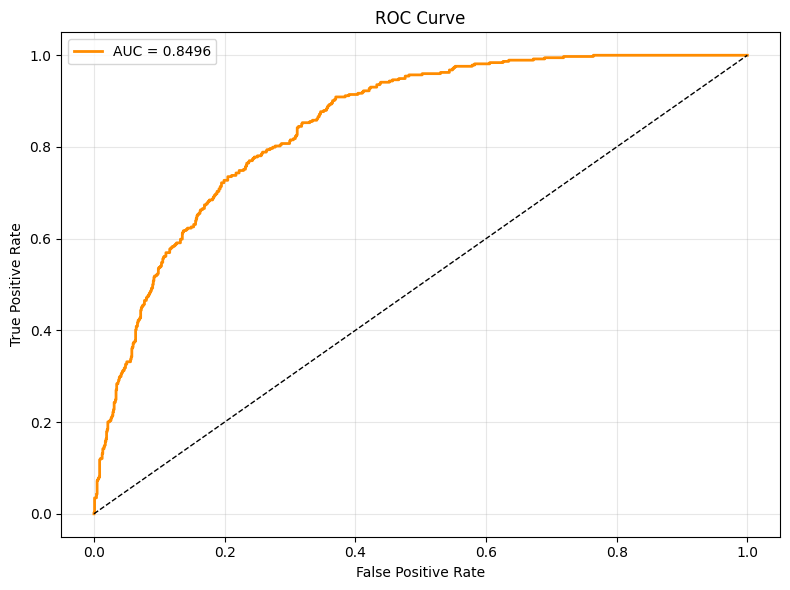

ROC-AUC: 0.8496


In [29]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f'ROC-AUC: {roc_auc:.4f}')

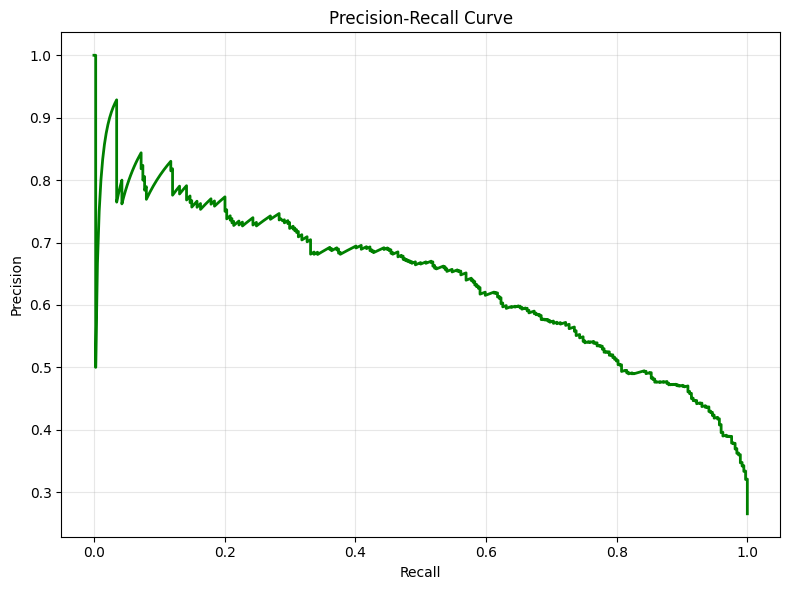

In [30]:
# Precision-Recall Curve
prec_vals, rec_vals, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(rec_vals, prec_vals, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [31]:
# -- Section 10: Save Model and Artifacts --

model_reg.save('churn_prediction_model.h5')
print('Model saved: churn_prediction_model.h5')

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print('Scaler saved: scaler.pkl')

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print('Label encoders saved: label_encoders.pkl')

with open('feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)
print('Feature names saved: feature_names.pkl')

print('\nAll artifacts saved.')

Model saved: churn_prediction_model.h5
Scaler saved: scaler.pkl
Label encoders saved: label_encoders.pkl
Feature names saved: feature_names.pkl

All artifacts saved.
